# Data Cleanup for Various Future Datafeeds

# Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0

!python --version

Python 3.11.8


# Cloud Environment Setup

In [2]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from pandas.tseries.offsets import BDay, Day
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

warnings.filterwarnings("ignore")

CLEAN_DATA_PATH = f".{os.sep}data"
DATA_PATH = f".{os.sep}data{os.sep}unstructureddata"
print("running localhost!")

running localhost!


# Get Data

In [3]:
from constants import *

class StockFeat:
    DATETIME = "Datetime"
    OPEN = "Open"
    HIGH = "High"
    LOW = "Low"
    CLOSE = "Close"
    VOLUME = "Volume"
    list = [OPEN, HIGH, LOW, CLOSE, VOLUME]


PERIOD_PD_FREQ = {
    YFinanceOptions.M1: '1T',
    YFinanceOptions.M15: '15T',
}

INTERVAL = YFinanceOptions.M15
DATE_TIME_FORMAT = "%Y-%m-%d"
END_DATE = pd.Timestamp(datetime.now()).strftime(DATE_TIME_FORMAT)
START_DATE =  pd.Timestamp(datetime.now() - Day(YFinanceOptions.MIN15_RANGE)).strftime(DATE_TIME_FORMAT)

print(FUTS)

['ZC', 'ZL', 'KE', 'ZS', 'ZM', 'ZW', 'LE', 'HE', 'GF', 'GC', 'SI', 'HG', 'PL', 'PA', 'CL', 'NG', 'HO', 'ES', 'NQ', 'VX', 'RTY', '2Y', '10Y']


In [4]:
import yfinance as yf
from scipy.stats import skew, kurtosis

def get_yf_tickers_df(tickers_symbols, start, end, interval=INTERVAL, datadir=DATA_PATH):
    tickers = {}
    earliest_end= pd.to_datetime(datetime.strptime(end,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    latest_start = pd.to_datetime(datetime.strptime(start,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    os.makedirs(datadir, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        print(f"Checking file: {cached_file_path}")
        if os.path.exists(cached_file_path):
            print(f"loading from {cached_file_path}")
            df = pd.read_csv(cached_file_path, parse_dates= True, index_col=0)
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
            assert len(df) > 0, "Empty data"
        else:
            df = yf.download(
                symbol,
                start=start,
                end=end,
                progress=True,
                interval=interval
            )
            assert len(df) > 0, "No data pulled"
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
        # Use adjusted close if available.
        if 'Adj Close' in df.columns:
            assert 'Close' in df.columns
            df.drop(columns=['Adj Close'], inplace=True)
            # df.rename(columns={'Adj Close': 'Close'}, inplace=True)
        min_date = df.index.min()
        max_date = df.index.max()
        nan_count = df["Close"].isnull().sum()
        skewness = round(skew(df["Close"].dropna()), 2)
        kurt = round(kurtosis(df["Close"].dropna()), 2)
        outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
        print(
            f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
        )
        tickers[symbol] = df

        if min_date > latest_start:
            latest_start = min_date
        if max_date < earliest_end:
            earliest_end = max_date

    nyse = mcal.get_calendar('CME_Agriculture')
    schedule = nyse.schedule(start_date=latest_start, end_date=earliest_end)
    all_trading_days = mcal.date_range(schedule, frequency=PERIOD_PD_FREQ[interval], tz='UTC', normalize=True)

    for symbol, df in tickers.items():
        df_filtered = df[(df.index >= latest_start) & (df.index <= earliest_end)]
        df_reindexed = df_filtered.reindex(all_trading_days, method='nearest')
        df_reindexed.index = pd.to_datetime(df_reindexed.index)
        df_reindexed = df_reindexed[~df_reindexed.index.duplicated(keep='first')]
        df_reindexed.index.name = 'Date'
        df_reindexed = df_reindexed.bfill().ffill()
        tickers[symbol] = df_reindexed

        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        if not os.path.exists(cached_file_path):
            df_reindexed.to_csv(cached_file_path, index=True)

    return tickers, latest_start, earliest_end

def load_all_csv_files(tickers_symbols=FUTS, interval=INTERVAL, datadir=DATA_PATH):
    tickers = {}
    earliest_end = None
    latest_start = None

    for symbol in os.listdir(datadir):
        symbol_path = os.path.join(datadir, symbol)
        if os.path.isdir(symbol_path):
            symbol_dfs = []
            for root, _, files in os.walk(symbol_path):
                for file_name in files:
                    if file_name.endswith('.csv'):
                        file_path = os.path.join(root, file_name)
                        print(f"Loading {file_path}")
                        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
                        try:
                            df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
                        except Exception as e:
                            df.index = pd.to_datetime(df.index).tz_convert('UTC')
                        df.columns = [f"{col.capitalize()}" for col in df.columns]
                        symbol_dfs.append(df)

            if symbol_dfs:
                df = pd.concat(symbol_dfs).sort_index()
                df = df[~df.index.duplicated(keep='first')]

                min_date = df.index.min()
                max_date = df.index.max()
                nan_count = df["Close"].isnull().sum()
                data_skew = round(skew(df["Close"].dropna()), 2)
                data_kurtosis = round(kurtosis(df["Close"].dropna()), 2)
                outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
                print(
                    f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurtosis: {data_kurtosis}, skewness: {data_skew}, outliers_count: {outliers_count}, nan_count: {nan_count}"
                )

                df.index.name = 'Date'
                tickers[symbol] = df

                if latest_start is None or min_date > latest_start:
                    latest_start = min_date
                if earliest_end is None or max_date < earliest_end:
                    earliest_end = max_date

                cached_file_path = f"{datadir}/{symbol}-{interval}.csv"
                df.to_csv(cached_file_path, index=True)

    return tickers, latest_start, earliest_end

# This loads a collection of files (e.g. from IBKR)
tickers, latest_start, earliest_end = load_all_csv_files()

# This gets from YFinance
# tickers, latest_start, earliest_end = get_yf_tickers_df(FUTS, start=START_DATE, end=END_DATE)
latest_start, earliest_end

Loading .\data\unstructureddata\10Y\20231229-20240128-15 mins.csv
Loading .\data\unstructureddata\10Y\20240128-20240227-15 mins.csv
Loading .\data\unstructureddata\10Y\20240227-20240328-15 mins.csv
Loading .\data\unstructureddata\10Y\20240328-20240427-15 mins.csv
Loading .\data\unstructureddata\10Y\20240427-20240527-15 mins.csv
10Y => min_date: 2023-12-29 01:00:00+00:00, max_date: 2024-05-27 01:45:00+00:00, kurtosis: -0.86, skewness: 0.15, outliers_count: 0, nan_count: 0
Loading .\data\unstructureddata\2YY\20231229-20240128-15 mins.csv
Loading .\data\unstructureddata\2YY\20240128-20240227-15 mins.csv
Loading .\data\unstructureddata\2YY\20240227-20240328-15 mins.csv
Loading .\data\unstructureddata\2YY\20240328-20240427-15 mins.csv
Loading .\data\unstructureddata\2YY\20240427-20240527-15 mins.csv
2YY => min_date: 2023-12-29 05:00:00+00:00, max_date: 2024-05-24 22:45:00+00:00, kurtosis: -1.07, skewness: 0.09, outliers_count: 0, nan_count: 0
Loading .\data\unstructureddata\CL\20231229-2024

(Timestamp('2023-12-29 05:00:00+0000', tz='UTC'),
 Timestamp('2024-05-24 20:00:00+0000', tz='UTC'))

De-duplicate and combine dataframes.

# Clean Data

In [5]:
for ticker in FUTS:
    file_pattern = f'{ticker}*.csv'
    files = glob.glob(f"{DATA_PATH}{os.sep}{ticker}*-{INTERVAL}.csv")
    assert files and len(files) > 0

    dataframes = []
    for file in files:
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        dataframes.append(df)

    combined_df = pd.concat(dataframes)
    combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
    combined_df.sort_index(inplace=True)
    combined_df.to_csv(f'{DATA_PATH}{os.sep}{ticker}-combined-{INTERVAL}.csv')

In [6]:
def get_prefix(filename):
    prefix = filename.split(os.sep)[-1].split("-")[0]
    return prefix

files = glob.glob(f'{DATA_PATH}{os.sep}*-combined-{INTERVAL}.csv')
assert files and len(files) > 0

fut_tickers = []
df_list = []

for f in files:
    print(f)
    prefix = get_prefix(f)
    fut_tickers.append(prefix)
    df_temp = pd.read_csv(f, index_col="Date", parse_dates=True)
    # TODO: Use bid ask here.
    df_temp["Spread"] = df_temp["High"] - df_temp["Low"]

    df_temp.columns = [prefix + "_" + col for col in df_temp.columns]
    df_temp = df_temp.apply(
        pd.to_numeric, errors="coerce"
    )

    df_list.append(df_temp)

.\data\unstructureddata\10Y-combined-15m.csv
.\data\unstructureddata\2Y-combined-15m.csv
.\data\unstructureddata\CL-combined-15m.csv
.\data\unstructureddata\ES-combined-15m.csv
.\data\unstructureddata\GC-combined-15m.csv
.\data\unstructureddata\GF-combined-15m.csv
.\data\unstructureddata\HE-combined-15m.csv
.\data\unstructureddata\HG-combined-15m.csv
.\data\unstructureddata\HO-combined-15m.csv
.\data\unstructureddata\KE-combined-15m.csv
.\data\unstructureddata\LE-combined-15m.csv
.\data\unstructureddata\NG-combined-15m.csv
.\data\unstructureddata\NQ-combined-15m.csv
.\data\unstructureddata\PA-combined-15m.csv
.\data\unstructureddata\PL-combined-15m.csv
.\data\unstructureddata\RTY-combined-15m.csv
.\data\unstructureddata\SI-combined-15m.csv
.\data\unstructureddata\VX-combined-15m.csv
.\data\unstructureddata\ZC-combined-15m.csv
.\data\unstructureddata\ZL-combined-15m.csv
.\data\unstructureddata\ZM-combined-15m.csv
.\data\unstructureddata\ZS-combined-15m.csv
.\data\unstructureddata\ZW-com

In [7]:
futs_df = pd.concat(df_list, axis=1)
try:
    futs_df.index = futs_df.index.tz_localize("GMT")
except Exception as e:
    print(e)
    # Probably already TZ aware
futs_df.sort_index(inplace=True)
futs_df = futs_df.iloc[futs_df.notnull().all(axis=1).argmax() :]
futs_df.interpolate(method="time", inplace=True)

assert not futs_df.isnull().any().any()
print(fut_tickers)
print(f"Dataset Shape: {futs_df.shape}")

futs_df.head(2)

Already tz-aware, use tz_convert to convert.
['10Y', '2Y', 'CL', 'ES', 'GC', 'GF', 'HE', 'HG', 'HO', 'KE', 'LE', 'NG', 'NQ', 'PA', 'PL', 'RTY', 'SI', 'VX', 'ZC', 'ZL', 'ZM', 'ZS', 'ZW']
Dataset Shape: (9494, 184)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2Y_Open,2Y_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


In [8]:
PRICE_COLS =["Close", "Open", "High", "Low", "Spread"]
def create_fut_rets_df(df, price_types = PRICE_COLS):
    log_data = {}
    pct_change_data = {}

    for price_type in tqdm(price_types):
        for column in tqdm(df.columns):
            if price_type in column:
                log_data[f"{column}_lp"] = np.log(df[column])
                pct_change_data[f"{column}_pc"] = df[column].pct_change() * 100
    log_fut_df = pd.DataFrame(log_data, index=df.index).bfill()
    pct_changes_df = pd.DataFrame(pct_change_data, index=df.index).bfill()
    combined_df = pd.concat([log_fut_df, pct_changes_df], axis=1)

    return combined_df

fut_rets_df = create_fut_rets_df(futs_df)
fut_rets_df.tail(2)

100%|██████████| 5/5 [00:00<00:00, 81.23it/s]


,10Y_Close_lp,2Y_Close_lp,CL_Close_lp,ES_Close_lp,GC_Close_lp,GF_Close_lp,HE_Close_lp,HG_Close_lp,HO_Close_lp,KE_Close_lp,...,PA_Spread_pc,PL_Spread_pc,RTY_Spread_pc,SI_Spread_pc,VX_Spread_pc,ZC_Spread_pc,ZL_Spread_pc,ZM_Spread_pc,ZS_Spread_pc,ZW_Spread_pc
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,1.350667,1.431268,4.278470,8.483223,7.636125,5.409635,4.326448,1.361233,0.919127,6.470800,...,133.333333,90.47619,-32.432432,-39.285714,-33.333333,-60.0,40.0,-62.962963,-30.0,-56.521739
2023-12-29 15:45:00+00:00,1.354546,1.431268,4.279717,8.482964,7.636366,5.408628,4.327768,1.362002,0.920920,6.471186,...,133.333333,90.47619,-32.432432,-39.285714,-33.333333,-60.0,40.0,-62.962963,-30.0,-56.521739


In [9]:
futs_df.to_csv(f"{CLEAN_DATA_PATH}{os.sep}futures_{INTERVAL}.csv")

# EDA

## Skew, Kurosis and Outliers

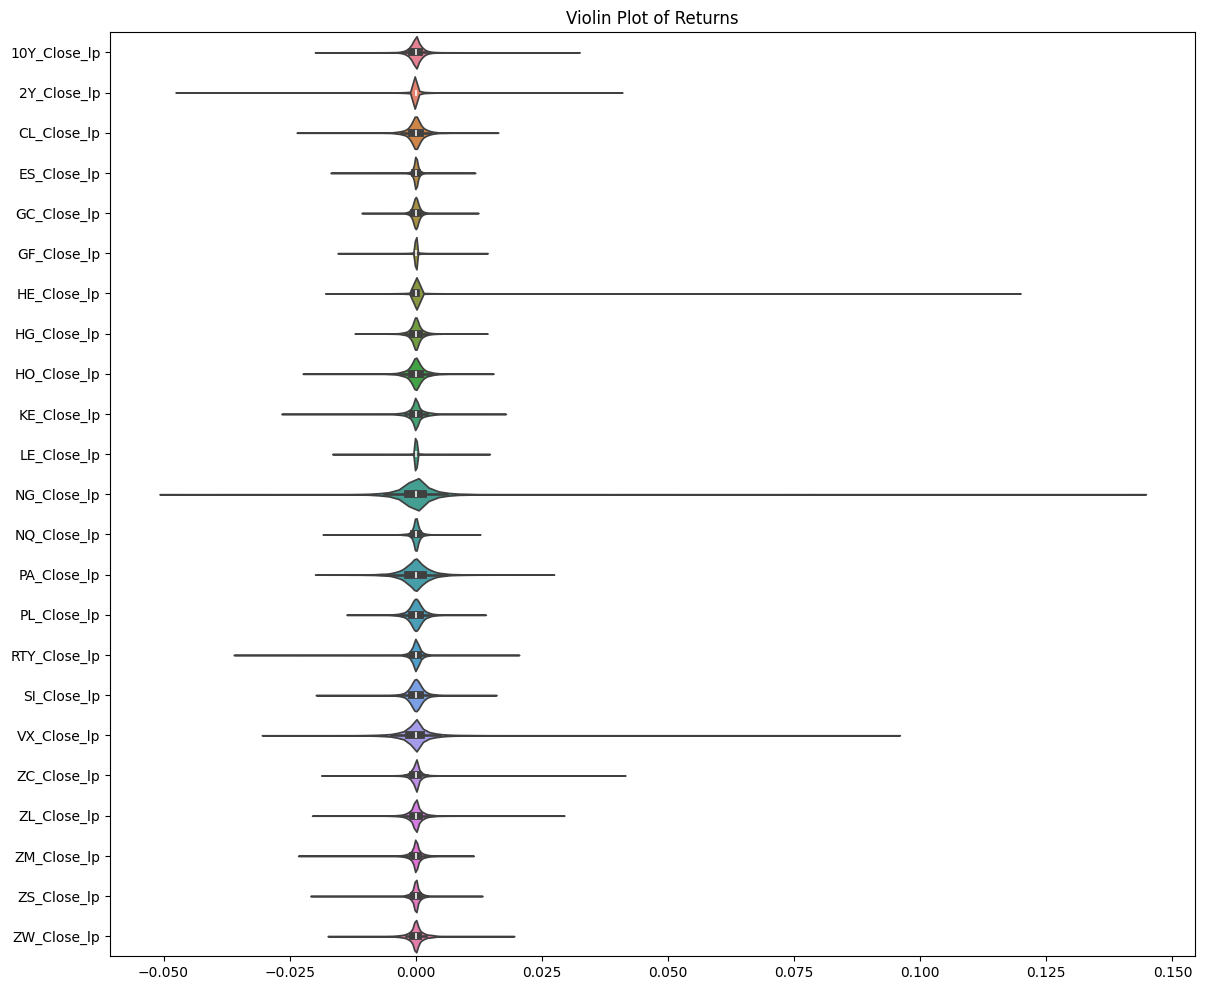

In [10]:
fut_lp = fut_rets_df.filter(regex="^.*Close_lp")
fut_lr = fut_lp.diff(1).fillna(0)
plt.figure(figsize=(14, 12))
ax = sns.violinplot(data=fut_lr, orient='h', scale='width')

plt.title("Violin Plot of Returns")
plt.show()

## Data Mining for Correlations


## Autoregressive

In [11]:
from statsmodels.tsa.stattools import pacf
from tqdm import tqdm
from scipy.stats import norm

def get_significant_lags(series, alpha=0.05):
    pacf_values = pacf(series.dropna(), nlags=40)
    n = len(series.dropna())
    z_critical = norm.ppf(1 - alpha / 2)  # two-tailed test
    critical_value = z_critical / np.sqrt(n) # the PCF value
    significant_lags = [i for i, p in enumerate(pacf_values) if abs(p) > critical_value]
    significant_lags = significant_lags[2:] # Drop lag 0,1, its always AR
    significant_pacf_values = [p for p in pacf_values if abs(p) > critical_value]
    significant_pacf_values = significant_pacf_values[2:]
    return significant_lags, significant_pacf_values

def get_ar_stats(df, alpha=0.05):
    df.index = pd.DatetimeIndex(df.index).to_period('T')
    ar_results = []
    for col in tqdm(df.columns, desc="get_ar_stats"):
        significant_lags, significant_pacf_values = get_significant_lags(df[col], alpha)
        ar_results.append({
            'Futs': col,
            'Lags': significant_lags,
            'PACF Values': significant_pacf_values
        })

    ar_df = pd.DataFrame(ar_results)
    return ar_df

ar_df = get_ar_stats(futs_df.filter(regex='_Close$'))
ar_df


get_ar_stats: 100%|██████████| 23/23 [00:00<00:00, 57.27it/s]


,Futs,Lags,PACF Values
0,10Y_Close,"[2, 4, 6, 8, 31]","[0.05202021253604429, 0.021319828085458202, -0..."
1,2Y_Close,"[2, 5, 8, 16, 31]","[0.10088100686414007, 0.028080774550202723, 0...."
2,CL_Close,"[11, 22, 31, 39]","[0.026892327361144525, 0.0215768479763185, 0.0..."
3,ES_Close,"[3, 19]","[-0.022887634351326246, -0.02259510708836075]"
4,GC_Close,"[7, 13, 38, 40]","[0.03334340420827784, 0.032682011931332355, -0..."
5,GF_Close,"[4, 7, 31]","[-0.030359179424360113, 0.020713345169157762, ..."
6,HE_Close,"[5, 7, 9, 11, 19]","[-0.027145381952608634, -0.02104604471196879, ..."
7,HG_Close,"[15, 17, 27, 32, 36]","[-0.02517614572805481, 0.021332851069555615, -..."
8,HO_Close,"[5, 20]","[0.033305279488928786, 0.02069397889947294]"
9,KE_Close,"[20, 25, 27, 31]","[0.023311773937470946, 0.027805299427871365, -..."


In [12]:
def find_common_lags(ar_df):
    lag_dict = {}
    for index, row in ar_df.iterrows():
        for lag in row['Lags']:
            if lag in lag_dict:
                lag_dict[lag].append(row['Futs'])
            else:
                lag_dict[lag] = [row['Futs']]

    common_lags = {lag: futs for lag, futs in lag_dict.items() if len(futs) > 1}

    common_lags_df = pd.DataFrame(list(common_lags.items()), columns=['Lag', 'Futs'])
    common_lags_df['Futs'] = common_lags_df['Futs'].apply(lambda futs: ', '.join(futs))

    return common_lags_df


commmon_ar_df = find_common_lags(ar_df)
commmon_ar_df

,Lag,Futs
0,2,"10Y_Close, 2Y_Close, NQ_Close, PA_Close, PL_Cl..."
1,4,"10Y_Close, GF_Close, LE_Close, VX_Close, ZL_Close"
2,8,"10Y_Close, 2Y_Close, RTY_Close, VX_Close, ZL_C..."
3,31,"10Y_Close, 2Y_Close, CL_Close, GF_Close, KE_Cl..."
4,5,"2Y_Close, HE_Close, HO_Close, ZL_Close, ZS_Close"
5,16,"2Y_Close, ZL_Close"
6,11,"CL_Close, HE_Close"
7,22,"CL_Close, ZL_Close"
8,3,"ES_Close, PA_Close, VX_Close, ZS_Close"
9,19,"ES_Close, HE_Close, NG_Close, NQ_Close, RTY_Close"


## Correlations between Futures

In [13]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
from itertools import combinations

LAGS = [1, 4, 16, 32]
MAX_DIFF = 2


def make_stationary(series, max_diff=MAX_DIFF):
    result = adfuller(series.dropna(), autolag="AIC")
    p_value = result[1]
    if p_value < 0.05:
        return series, 0

    diff_count = 0
    differenced_series = series.copy()
    while p_value >= 0.05 and diff_count < max_diff:
        differenced_series = differenced_series.diff().dropna()
        result = adfuller(differenced_series, autolag="AIC")
        p_value = result[1]
        diff_count += 1
        if p_value < 0.05:
            break

    return differenced_series, diff_count


def calculate_correlations(data, lags=LAGS, alpha=0.05, corr_threshold=0.25):
    correlations = {}

    rets = data.filter(regex="(_Close_lp)$")
    pairs = list(combinations(rets.columns, 2))
    for col1, col2 in tqdm(pairs, desc="calculate_correlations", total=len(pairs)):
        series1, _ = make_stationary(rets[col1])
        series2, _ = make_stationary(rets[col2])

        for lag in lags:
            lagged_series2 = series2.shift(lag).dropna()
            truncated_series1 = series1.iloc[lag:]

            if len(truncated_series1) == 0 or len(truncated_series1) != len(lagged_series2):
                continue

            corr, p_value = pearsonr(truncated_series1, lagged_series2)
            if p_value < alpha and abs(corr) >= corr_threshold:
                correlations[((col1, col2), lag)] = (corr, p_value)

    return correlations

correlation_df = []
correlation_results = calculate_correlations(fut_rets_df)
if len(correlation_results) > 0:
    correlation_df = pd.DataFrame.from_dict(
        correlation_results, orient="index", columns=["Correlation", "P-Value"]
    )
    correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

correlation_df

calculate_correlations: 100%|██████████| 253/253 [07:03<00:00,  1.68s/it]


[]

## Data Mining for Co-Integrations

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import itertools
from numpy.linalg import LinAlgError

subsets = {
        'Market': MARKET_FUTS,
        'Metals': METALS_FUTS,
        'Energy': ENERGY_FUTS,
        'Agri': AGRI_FUTS,
        'All': FUTS
    }

def johansen_cointegration_test(df, alpha=0.05):
    assert df.shape[1] > 0

    data = df.values
    johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)

    trace_stat = johansen_result.lr1
    trace_crit_values = johansen_result.cvt

    def get_crit_index(alpha):
        alpha_levels = [0.10, 0.05, 0.01]
        if alpha in alpha_levels:
            return alpha_levels.index(alpha)
        else:
            raise ValueError(f"Alpha {alpha} out of valid range {alpha_levels}")

    crit_index = get_crit_index(alpha)
    num_cointegrated_vectors = sum(trace_stat > trace_crit_values[:, crit_index])
    return num_cointegrated_vectors, johansen_result

def run_johansen_on_subsets(fut_rets_df):
    results = []

    # Test each subset
    for subset_name, tickers in subsets.items():
        cols = [t+"_Close_lp" for t in tickers]
        filtered_df = fut_rets_df[cols]
        if len(filtered_df.columns) < 2:
            continue
        try:
            num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
            results.append({
                'Subset': subset_name,
                'Coints': num_coint_vectors
            })
        except LinAlgError as e:
            results.append({
                'Subset': subset_name,
                'Coints': None,
            })

    # Test combinations of subsets
    subset_keys = list(subsets.keys())
    for i in range(2, len(subset_keys) + 1):
        for combination in itertools.combinations(subset_keys, i):
            combined_name = ' + '.join(combination)
            combined_tickers = list(itertools.chain.from_iterable(subsets[key] for key in combination))
            cols = [t+"_Close_lp" for t in combined_tickers]
            filtered_df = fut_rets_df[cols]
            if len(filtered_df.columns) < 2 or len(filtered_df.columns) > 12:
                continue
            try:
                num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
                results.append({
                    'Subset': combined_name,
                    'Coints': num_coint_vectors
                })
            except LinAlgError as e:
                results.append({
                    'Subset': combined_name,
                    'Coints': 0,
                })

    return pd.DataFrame(results)

results = run_johansen_on_subsets(fut_rets_df)
results[results["Coints"] > 1].sort_values("Coints")

C:\Users\adamd\AppData\Local\Temp\ipykernel_42408\1267306016.py:17: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)


,Subset,Coints
2,Energy,2
6,Market + Energy,2


In [15]:
def get_all_futs_in_coint_subsets():
    coint_subset = set()
    for subset in results[results["Coints"] > 1]['Subset']:
        futures = subset.split(' + ')
        for future in futures:
            coint_subset.update(subsets[future])

    return coint_subset

# We can get a subset of all coint futures across industries, though we
# know there is strong coint in the equities and agri futures,
COINT_FUTS = get_all_futs_in_coint_subsets()
COINT_FUTS = MARKET_FUTS + AGRI_FUTS
print(COINT_FUTS)

['ES', 'NQ', 'VX', 'RTY', '2Y', '10Y', 'ZC', 'ZL', 'KE', 'ZS', 'ZM', 'ZW', 'LE', 'HE', 'GF']


In [16]:
from statsmodels.tsa.stattools import coint

def pairwise_cointegration_test(df, coint_cols, alpha=0.05):
    tickers = [t+"_Close_lp" for t in coint_cols]
    results = []

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            series1 = df[tickers[i]]
            series2 = df[tickers[j]]
            score, p_value, _ = coint(series1, series2)
            if p_value < alpha:
                results.append({
                    'Ticker1': tickers[i].split('_')[0],
                    'Ticker2': tickers[j].split('_')[0],
                    'P-Value': p_value
                })

    results_df = pd.DataFrame(results)
    return results_df


pairwise_coint_results = pairwise_cointegration_test(fut_rets_df, COINT_FUTS)

if not pairwise_coint_results.empty:
    pairwise_coint_results = pairwise_coint_results.sort_values(by='P-Value')
    print(pairwise_coint_results)
else:
    print("No meaningful pairwise cointegration within the supplied alpha")

  Ticker1 Ticker2   P-Value
3      ZC      ZM  0.026001
0      ES     RTY  0.034980
4      ZM      ZW  0.044075
1      NQ     RTY  0.045129
2      VX      ZS  0.045913


## Cummulative Returns Visualizations

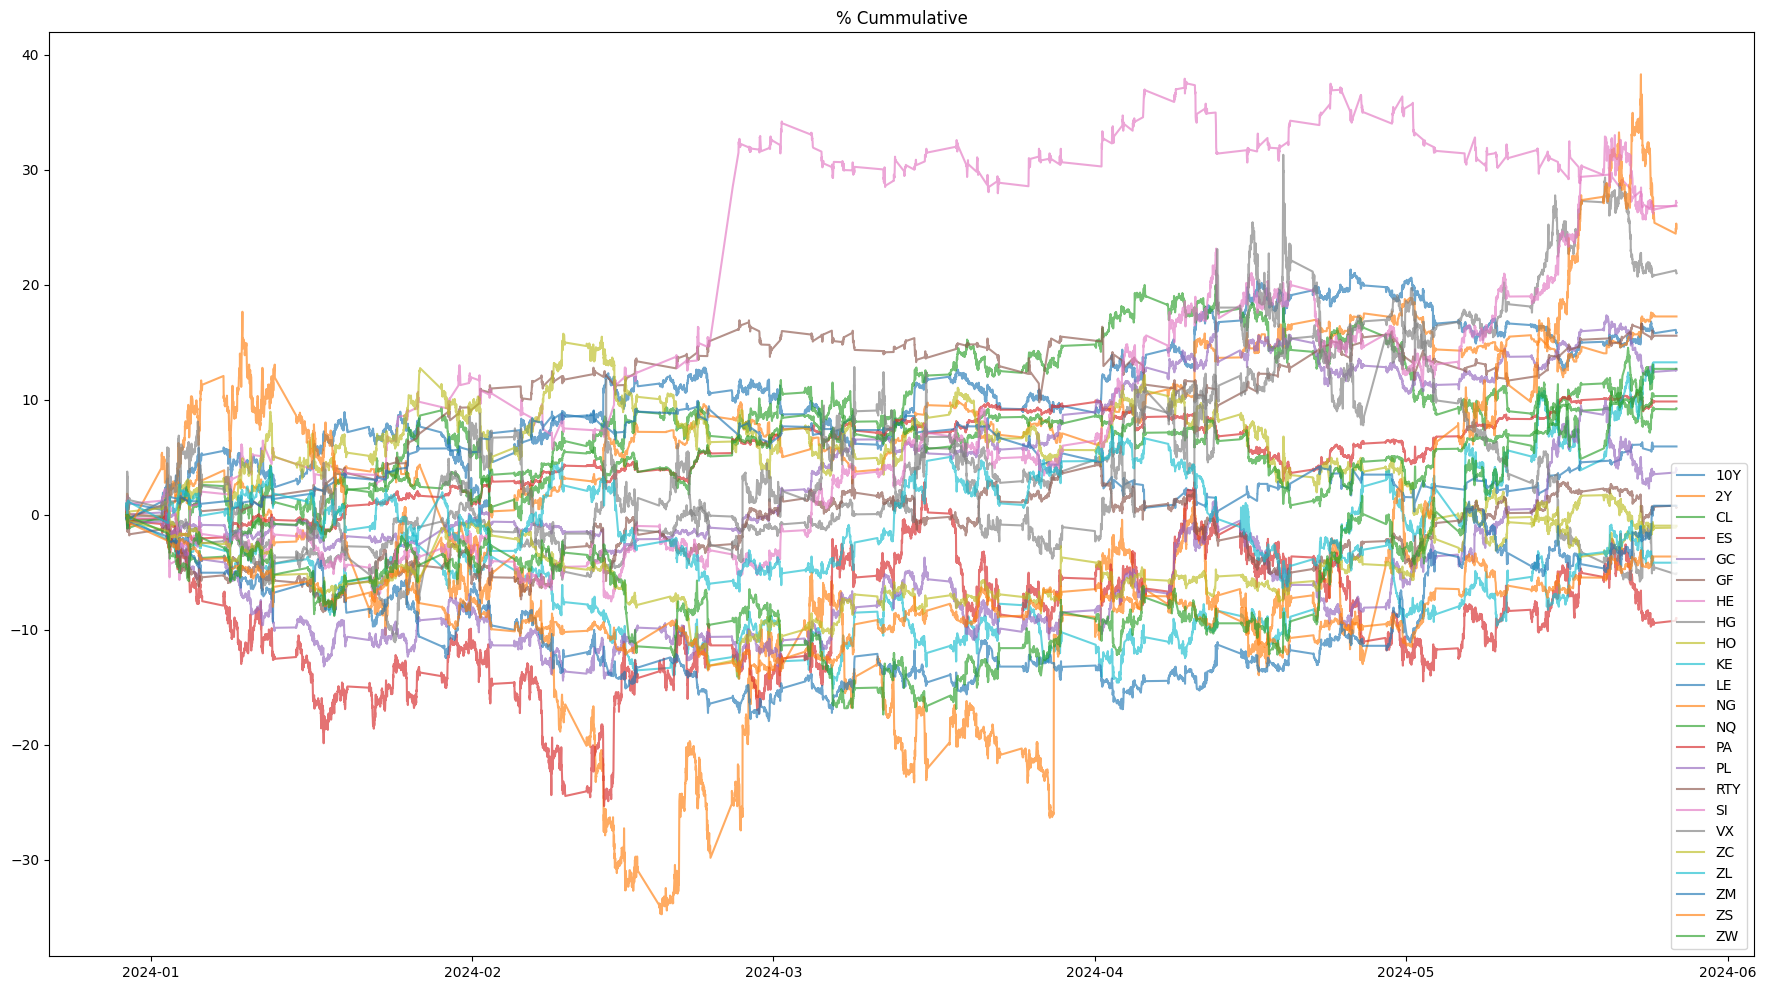

In [17]:
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc"):
        fut_rets_df[c + "_c"] = fut_rets_df[c].cumsum()

# Plotting
plt.figure(figsize=(22, 12))
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc_c"):
        plt.plot(fut_rets_df.index, fut_rets_df[c], label=c.replace("_Close_pc_c", ""), alpha=0.65)
plt.title("% Cummulative")
plt.legend()
plt.show()

## Distributions

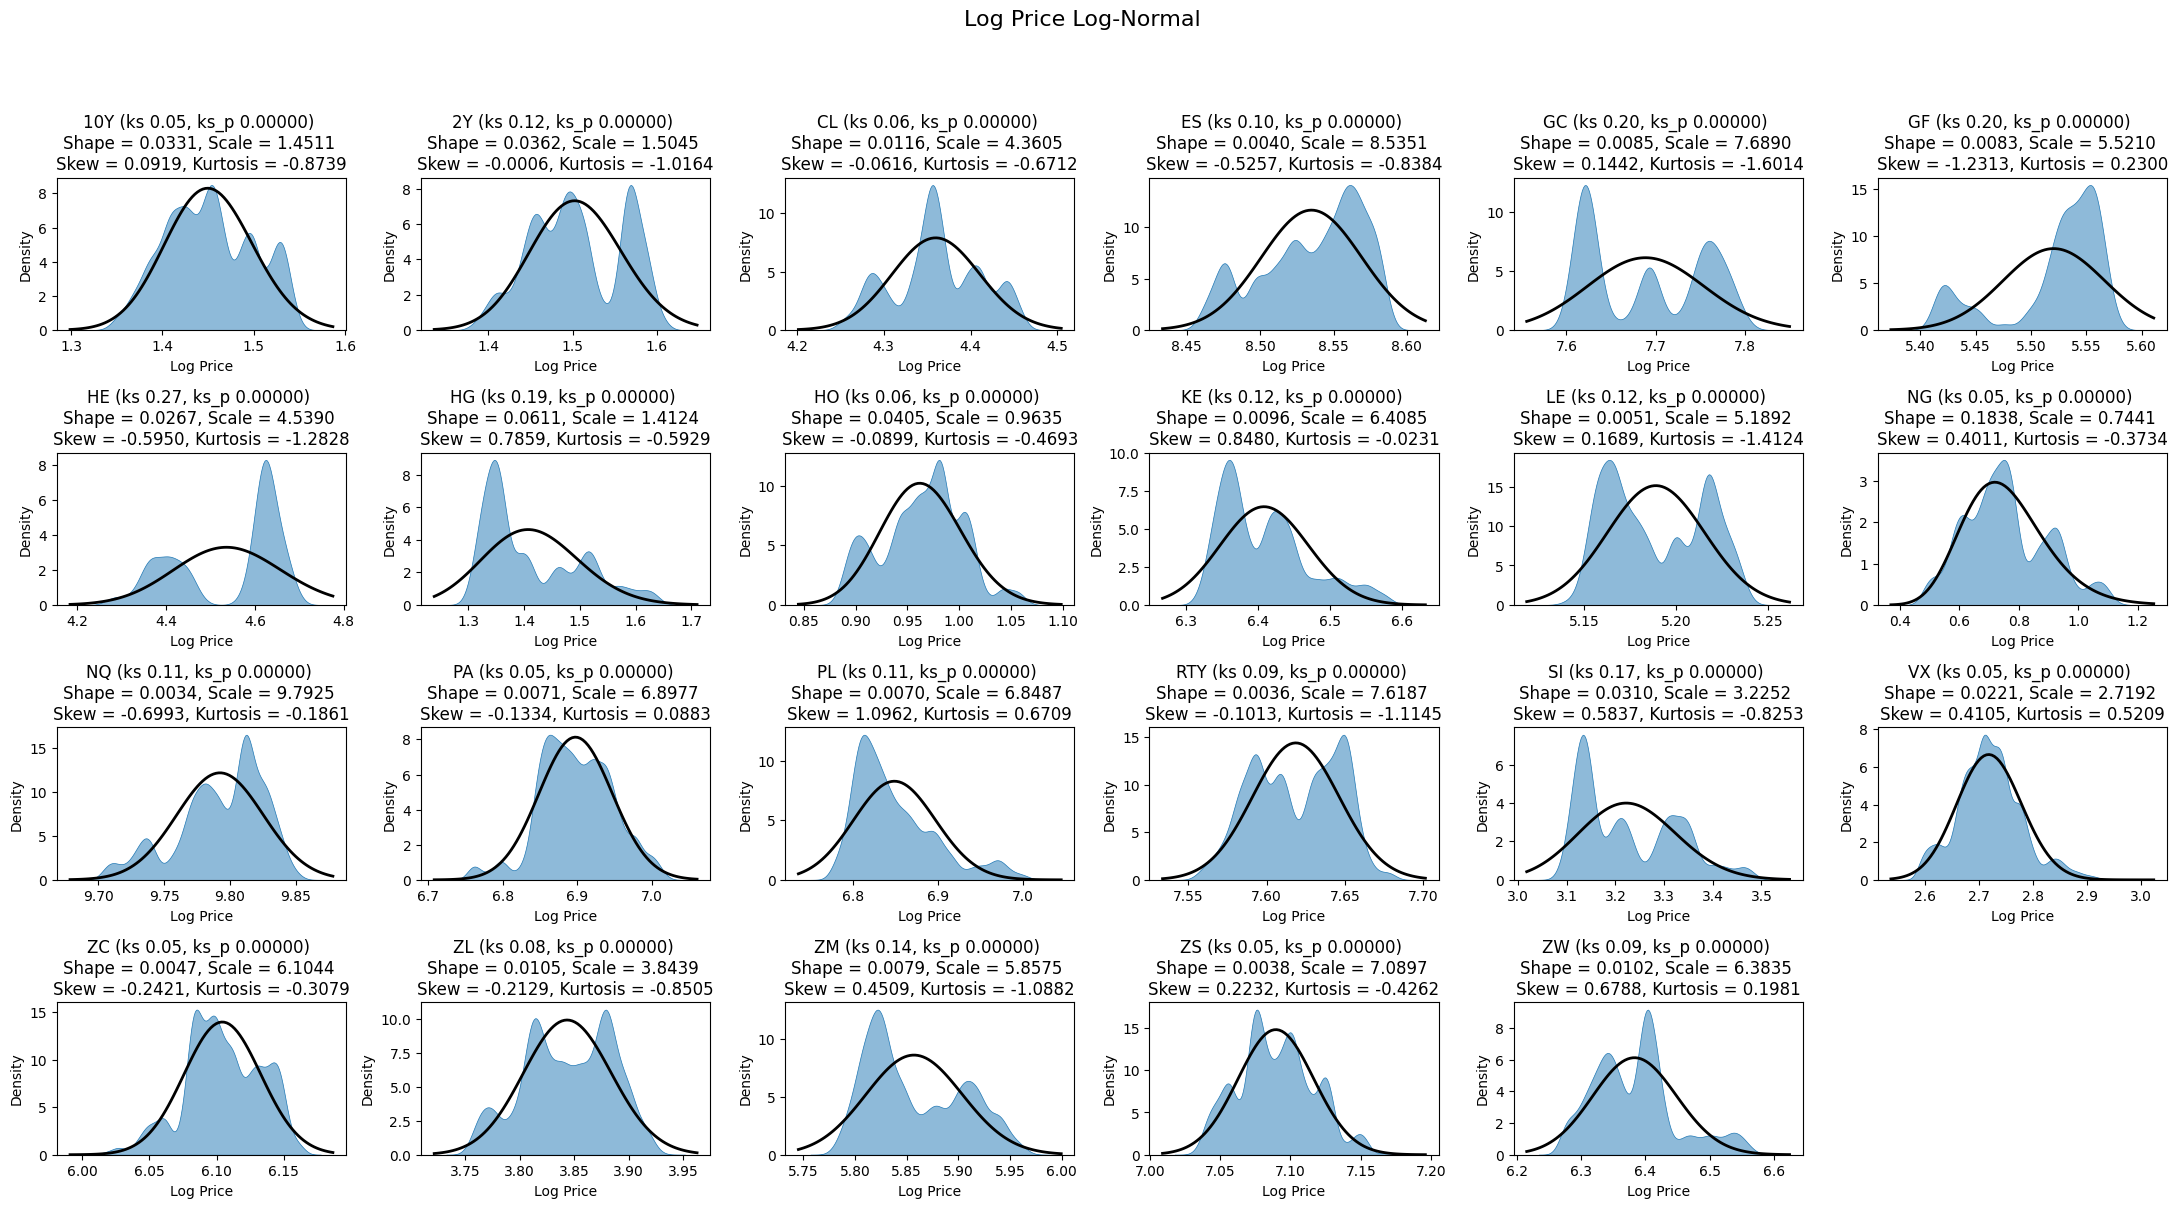

In [18]:
from scipy.stats import lognorm, kstest

def plot_lognorm(df):
    columns = df.filter(regex="(_Close(_lp)?)$").columns
    n_cols = len(columns)
    n_cols_adjusted = n_cols // 2 + (n_cols % 2)
    assert len(columns) > 0 and n_cols_adjusted > 0

    fig, axes = plt.subplots(nrows=max(n_cols_adjusted // 2, 1), ncols=max(n_cols_adjusted // 2, 1), figsize=(22, 18))
    axes = axes.flatten()
    fig.suptitle("Log Price Log-Normal", fontsize=16)
    for ax, column in zip(axes, columns):
        data = df[column].dropna()
        sns.kdeplot(
            data,
            fill=True,
            common_norm=False,
            alpha=0.5,
            linewidth=0.5,
            ax=ax
        )

        shape, loc, scale = lognorm.fit(data, floc=0)
        # Kolmogorov-Smirnov Test (KS Test)
        ks_stat, ks_p_value = kstest(data, 'lognorm', args=(shape, loc, scale))

        xmin, xmax = ax.get_xlim()

        x = np.linspace(xmin, xmax, 100)
        p = lognorm.pdf(x, shape, loc, scale)
        ax.plot(x, p, 'k', linewidth=2)

        data_skew = skew(data)
        data_kurtosis = kurtosis(data)

        title = (
            f"{column.split('_')[0]} (ks {ks_stat:.02f}, ks_p {ks_p_value:.05f}) \n"
            f"Shape = {shape:.04f}, Scale = {scale:.04f} \n"
            f"Skew = {data_skew:.04f}, Kurtosis = {data_kurtosis:.04f}"
        )
        ax.set_title(title)
        ax.set_xlabel("Log Price")
        ax.set_ylabel("Density")

    for ax in axes[len(columns):]:
        ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_lognorm(fut_rets_df)

In [19]:
from quant_equations import *

mr_attr = {}
for fut in FUTS:
    fut = fut
    hl, h = get_ou(futs_df, f"{fut}_Close")
    mr_attr[fut] = {'half_life': hl, 'hurst': h}

mr_attr_df = pd.DataFrame(mr_attr).transpose()
mr_attr_df.sort_values(by=['hurst', 'half_life'])

,half_life,hurst
LE,1073.0,-1.143496
GF,1462.0,-1.046786
HE,2533.0,-0.954235
2Y,1574.0,-0.549277
ZC,597.0,-0.545297
KE,8329.0,-0.481690
ZW,6351.0,-0.478571
ZL,677.0,-0.436394
ZS,435.0,-0.391046
ZM,1446.0,-0.349277
